In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import sys
sys.path.append("/home/cgarcia_2002/nHits_count")

import functions_nHits  # Importa la función que necesitas
import importlib

importlib.reload(functions_nHits)
%matplotlib inline

In [2]:
root_file_path = "/data/cgarcia_2002/WCTE/data/2384_calib_time/WCTE_offline_R2384S0P0.root" #bkg
#root_file_path = "/data/cgarcia_2002/WCTE/data/2385_calib_time/WCTE_offline_R2385S0P2.root"  #signal
# Open the ROOT file and get the TTree
file = uproot.open(root_file_path)

tree = file["WCTEReadoutWindows"]  
#tree.show()

In [4]:
times_branch = tree["hit_pmt_calibrated_times"].array(library="np")
event_number_branch = tree["event_number"].array(library="np")

times_branch = tree["hit_pmt_calibrated_times"].array(library="np")[0:10]
event_number_branch = tree["event_number"].array(library="np")[0:10]

range_hits = 10
times_array = np.arange(0, 271000+1, range_hits, dtype=int)
nHits = np.zeros((len(event_number_branch), len(times_array)))

for times, event_number in zip(times_branch, event_number_branch):

    nHits[event_number, :] = functions_nHits.count_nHits(times, range_hits, nHits[event_number, :])

In [5]:
print("nHits shape:", nHits.shape)
print("nHits:", nHits)
print(event_number_branch)

nHits shape: (10, 27101)
nHits: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0 1 2 3 4 5 6 7 8 9]


In [6]:
df_nHits = pd.DataFrame(nHits, columns=[str(t) for t in times_array])
df_nHits.insert(0, "event_number", event_number_branch)

In [7]:
# Crear un nuevo DataFrame con la suma hacia la derecha
df_SumWindow = pd.DataFrame()
# Excluir la columna "event_number"
only_counts = df_nHits.drop(columns="event_number")

# Ahora haces bien el sliding window
for i in range(len(only_counts.columns) - 4):
    col_name = only_counts.columns[i]
    sum_window = only_counts.iloc[:, i:i+5].sum(axis=1)
    df_SumWindow[col_name] = sum_window

 #no es dificil añadir que si pasa el threshold guarde el evento y tiempo y no cuente las siguientes ventanas
 #no se si vale la pena pk no hay tantas ventanas que pasen el threshold, y ns cuanto optimiza hacerlo para todas las filas a la vez
 #si se puede añadir saltar al siguiente evento


Max value: 908.0
Row index: 6
Column name: 200360


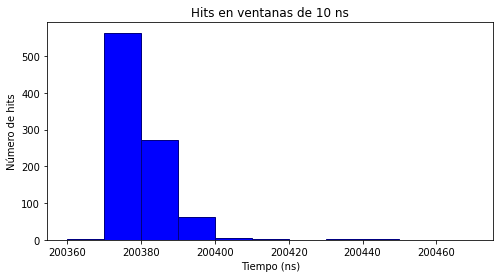

In [9]:
max_value = df_SumWindow.max(axis=1).max()  # Maximum value in the whole DataFrame
idx_row = df_SumWindow.max(axis=1).idxmax()  # Row index of the maximum value
col_name = df_SumWindow.loc[idx_row].idxmax()  # Column name of the maximum value in that row

print("Max value:", max_value)
print("Row index:", idx_row)
print("Column name:", col_name)

# Selecciona la columna inicial y las 10 siguientes
col_start = col_name
col_names = [str(int(col_start) + 10*i) for i in range(11)]

# Selecciona los datos (por ejemplo, de la primera fila)
row = df_nHits.loc[idx_row, col_names]

# Haz el plot
plt.figure(figsize=(8, 4))
plt.bar([int(c) for c in col_names], row.values, width=10, color='blue', align='edge', edgecolor='navy')
plt.xlabel('Tiempo (ns)')
plt.ylabel('Número de hits')
plt.title('Hits en ventanas de 10 ns')
plt.show()

In [10]:
threshold = 5
trigger_times = {}
jump_bins = 10
for idx, row in df_SumWindow.iterrows():
    i = 0
    trigger_times[idx] = []  # inicializa la lista para este evento
    while i < len(row):
        if row.iloc[i] >= threshold:
            # Guardamos el tiempo correspondiente a este trigger
            trigger_time = row.index[i]
            trigger_times[idx].append(trigger_time)
           
            """# Eliminamos los siguientes jump_bins columnas poniéndolas a 0
            end = min(i + jump_bins, len(row))
            row.iloc[i:end] = 0"""

            i += jump_bins  # saltamos
        else:
            i += 1

In [11]:
trigger_times = {k: v for k, v in trigger_times.items() if v}

print("Trigger times:", trigger_times)

with open('TriggerTimes_signal.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for clave, lista in trigger_times.items():
        writer.writerow([clave] + lista)


Trigger times: {0: ['222060', '225110'], 1: ['58230', '74160', '79610', '82680', '82890'], 2: ['17040', '40670', '91820', '239000'], 3: ['88700'], 4: ['99400', '119960'], 5: ['88590'], 6: ['119960', '200330', '200580', '203500', '203610', '203710'], 7: ['110850', '160610', '194400'], 8: ['119970'], 9: ['140550', '141190', '143310', '143860', '242270']}


In [61]:
trigger_times = {}

with open('TriggerTimes_bkg.csv', 'r') as f:
    reader = csv.reader(f)
    for fila in reader:
        if not fila:
            continue  # saltar filas vacías
        clave = fila[0]
        valores = fila[1:]
        trigger_times[clave] = valores

print(trigger_times)


{'0': ['222060', '225110'], '1': ['58230', '74160', '79610', '82680', '82890'], '2': ['17040', '40670', '91820', '239000'], '3': ['88700'], '4': ['99400', '119960'], '5': ['88590'], '6': ['119960', '200330', '200580', '203500', '203610', '203710'], '7': ['110850', '160610', '194400'], '8': ['119970'], '9': ['140550', '141190', '143310', '143860', '242270'], '11': ['198730', '201350', '201890', '202060', '202160'], '12': ['258490', '261780'], '13': ['9770', '46210', '126010', '128640', '129690', '147930', '209060'], '14': ['26470', '66480', '72210', '154030', '156930', '157410', '157510', '232870', '255960'], '15': ['25050', '52770'], '16': ['131190', '131360'], '17': ['54770', '101130', '104010', '104520', '104710', '104870'], '19': ['188120', '253820'], '20': ['56160', '203420'], '21': ['19840', '70010', '123860', '193160', '195200'], '22': ['47240'], '23': ['54650', '59610', '91160', '180520'], '24': ['42240'], '25': ['219350', '233950', '247540', '250300', '250440', '250760', '25088

{0: ['222060', '225110'], 1: ['58230', '74160', '79610', '82680', '82890'], 2: ['17040', '40670', '91820', '239000'], 3: ['88700'], 4: ['99400', '119960'], 5: ['88590'], 6: ['119960', '200330', '200580', '203500', '203610', '203710'], 7: ['110850', '160610', '194400'], 8: ['119970'], 9: ['140550', '141190', '143310', '143860', '242270']}


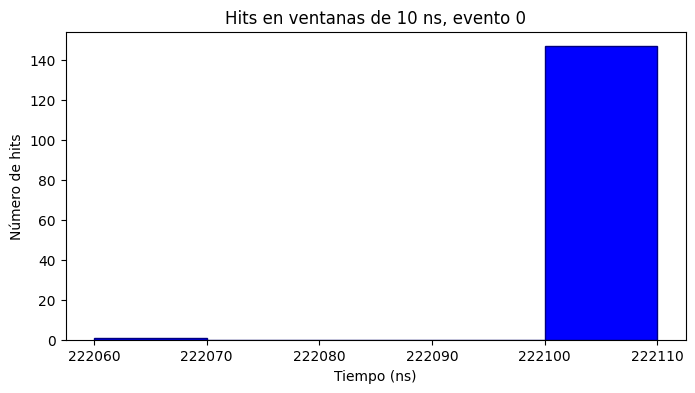

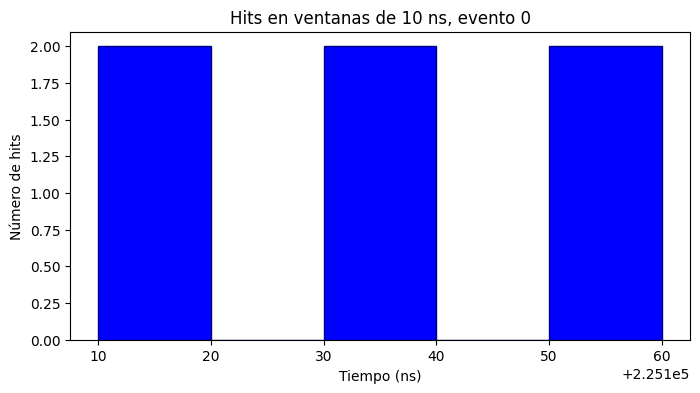

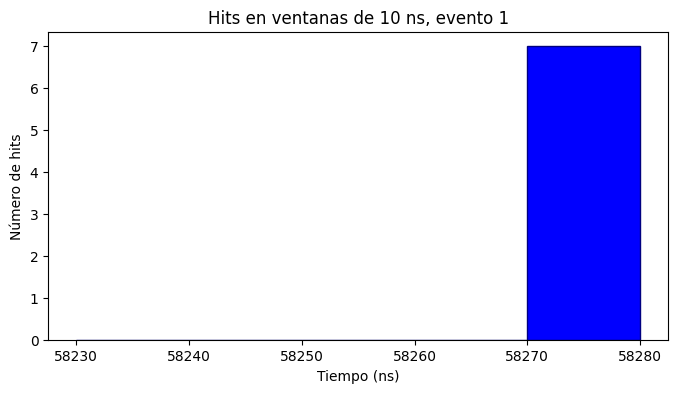

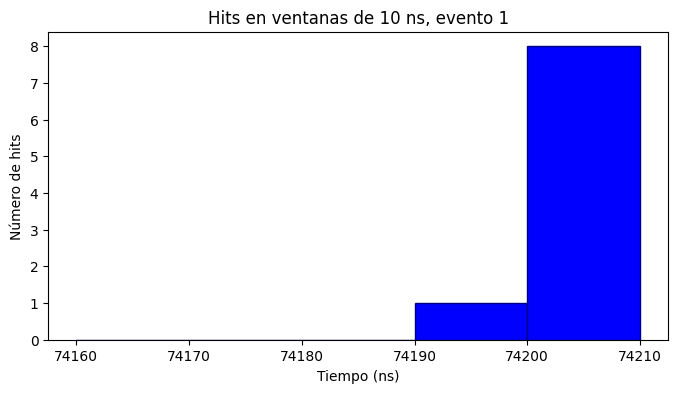

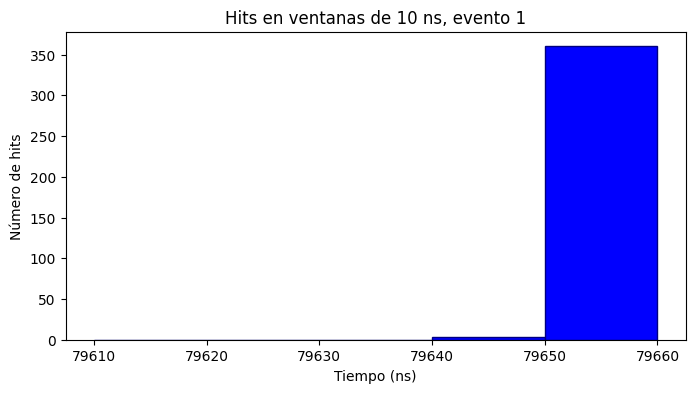

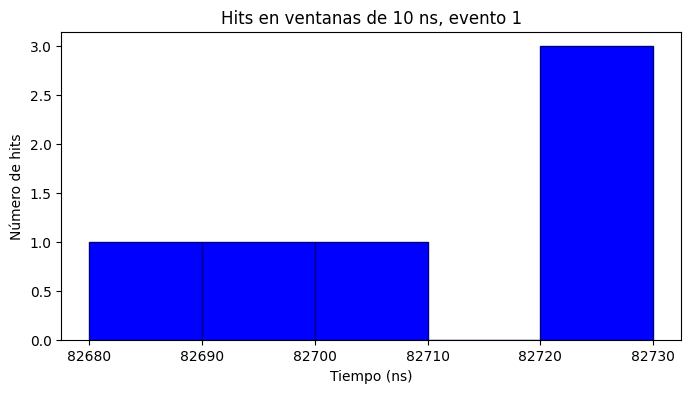

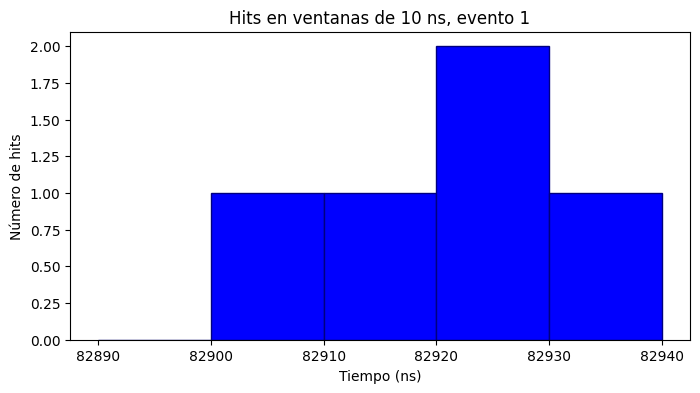

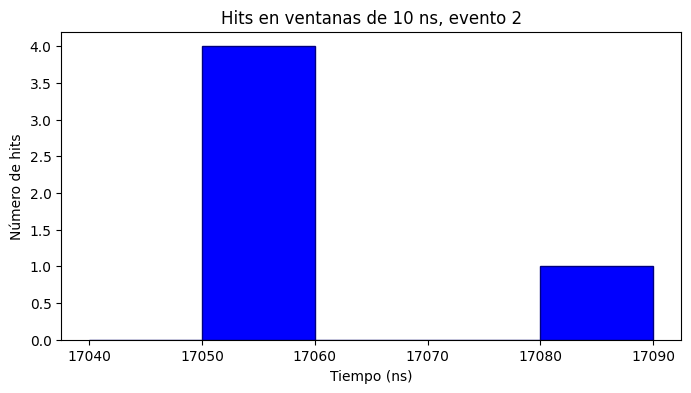

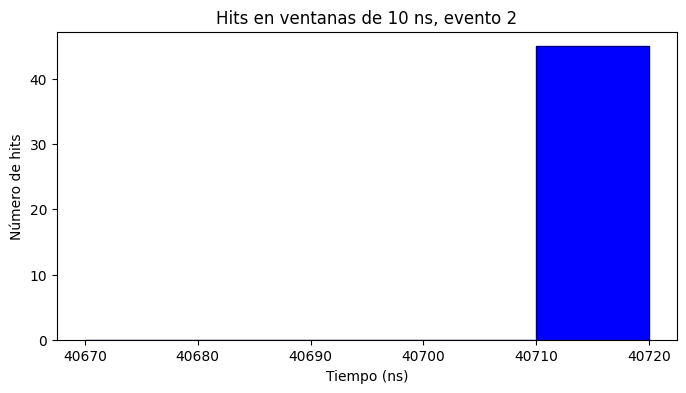

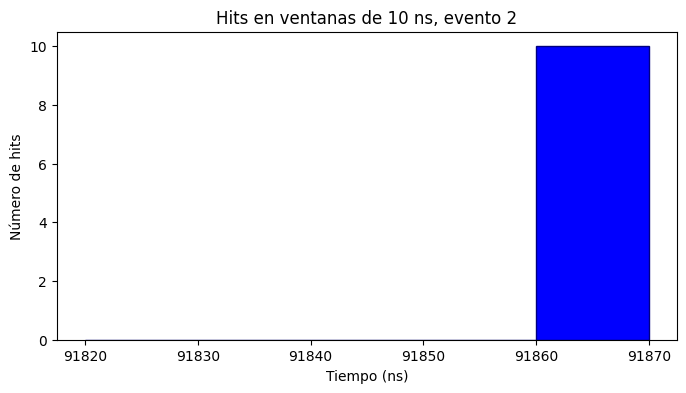

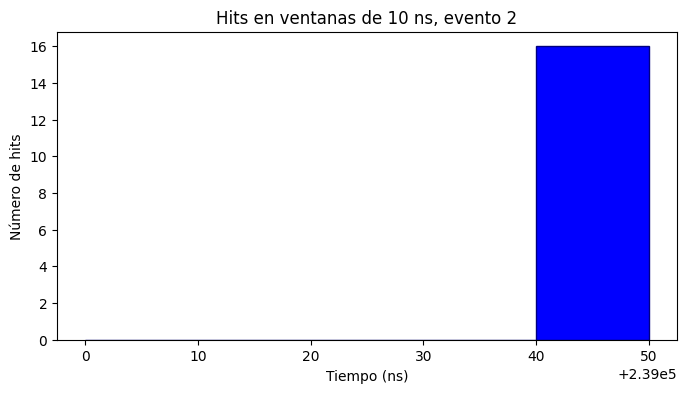

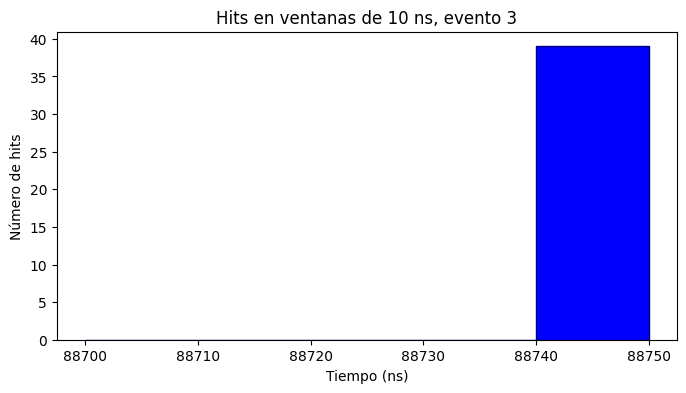

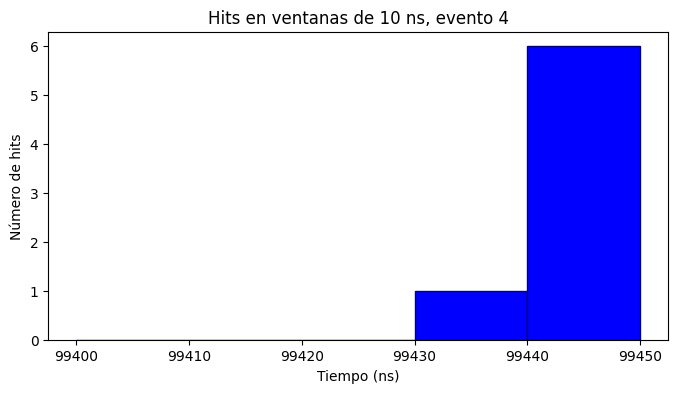

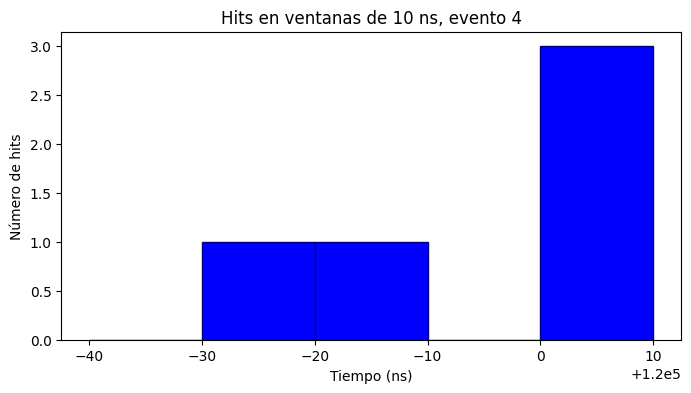

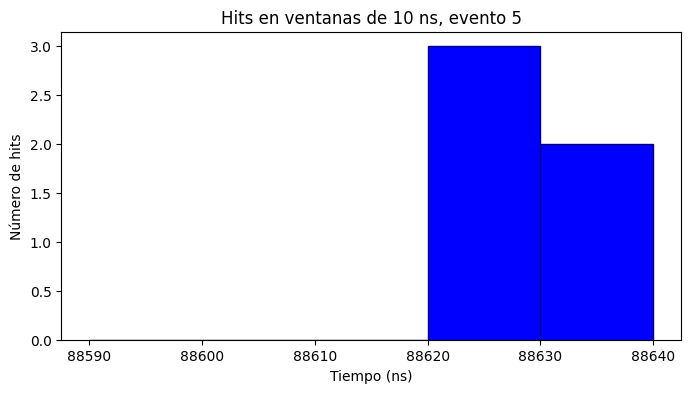

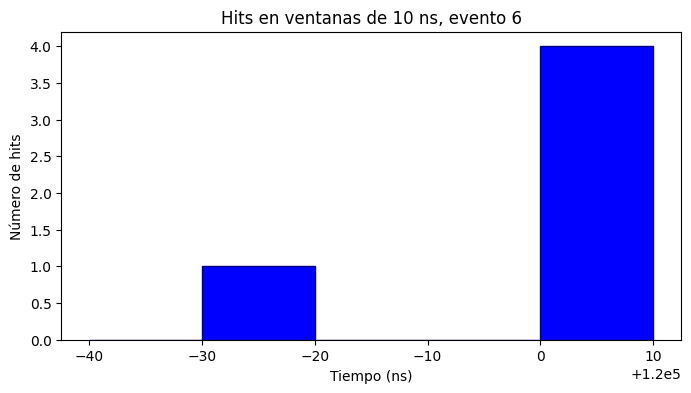

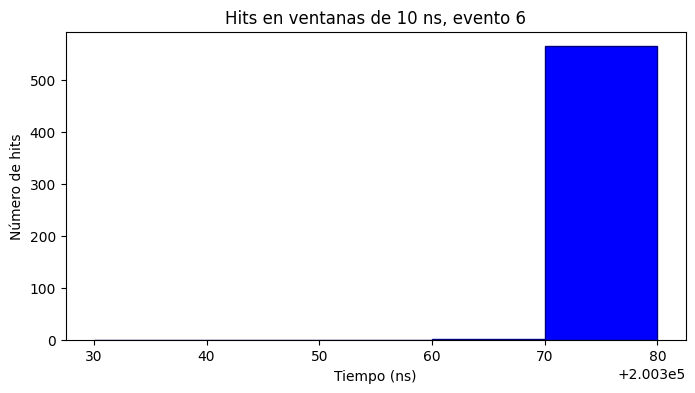

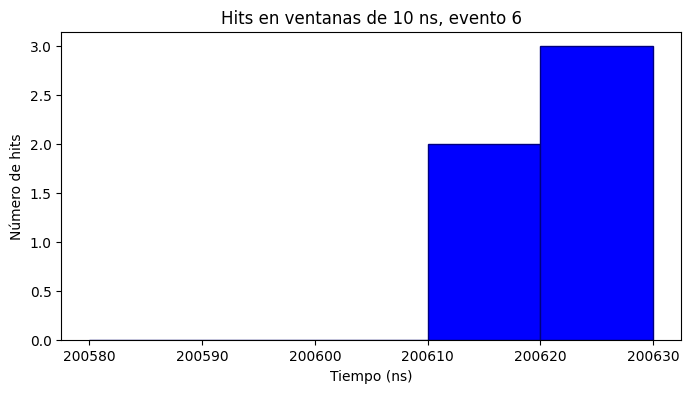

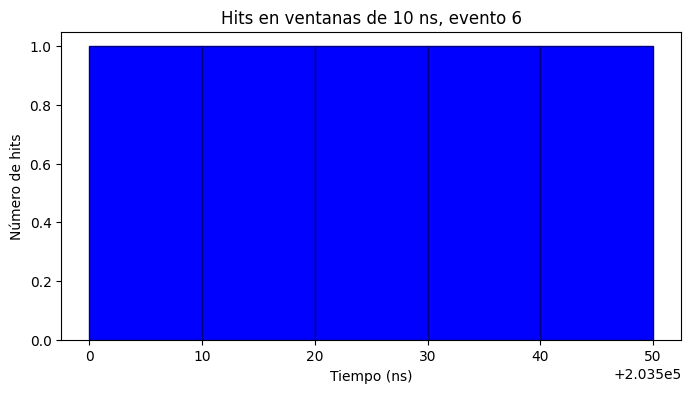

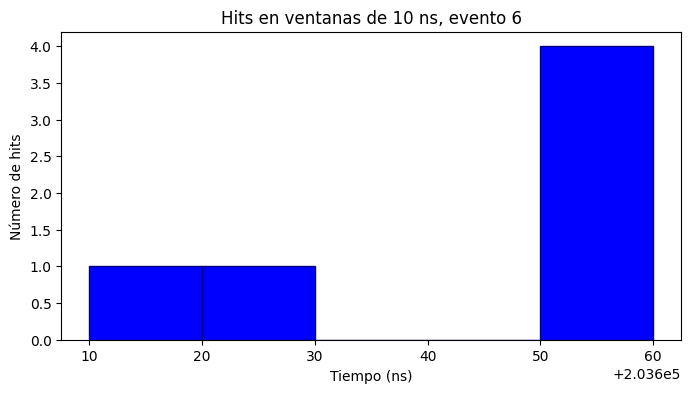

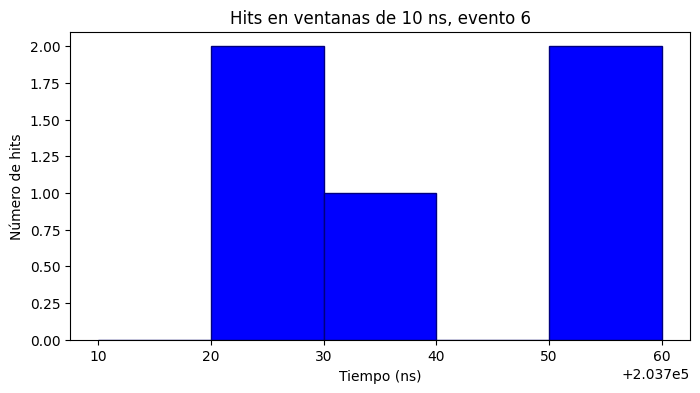

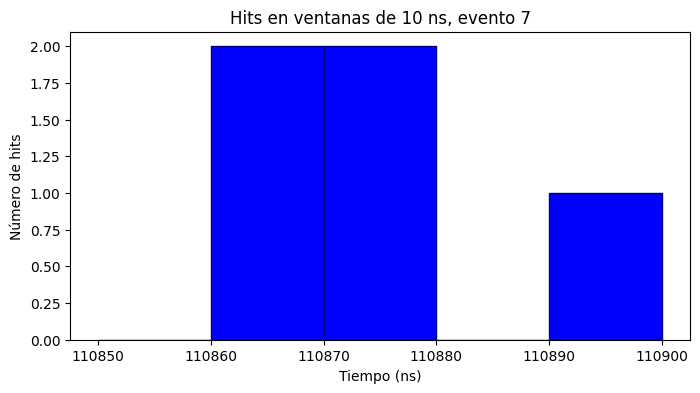

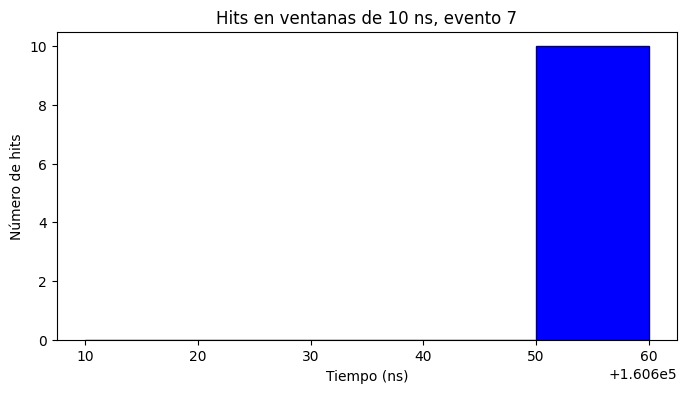

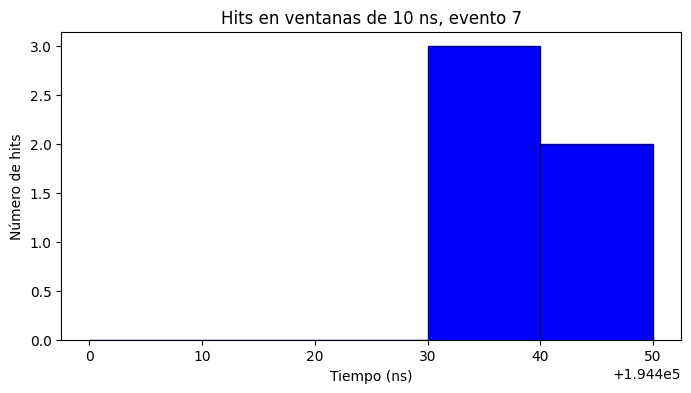

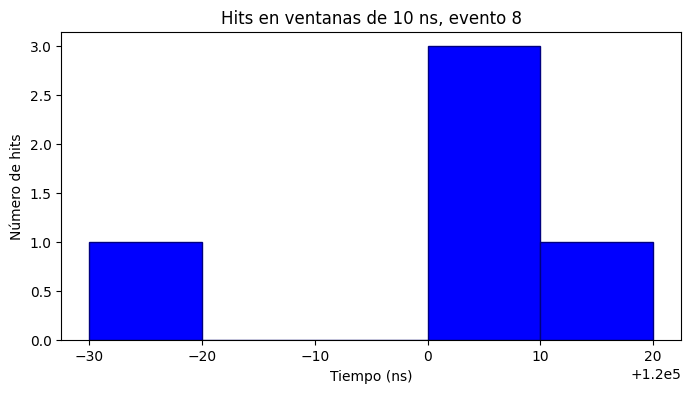

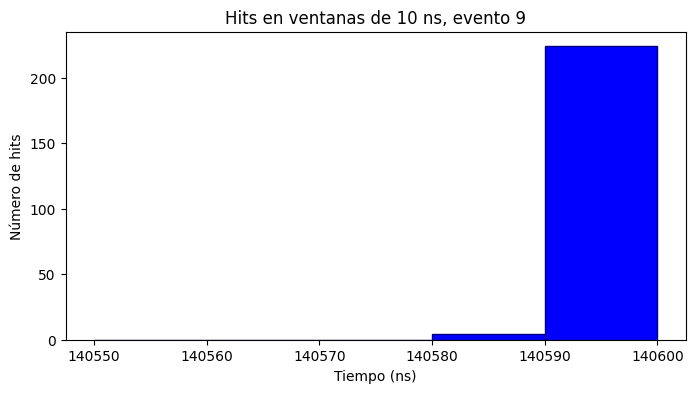

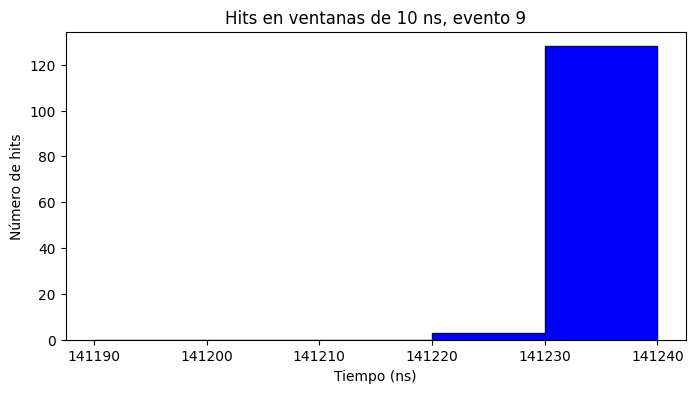

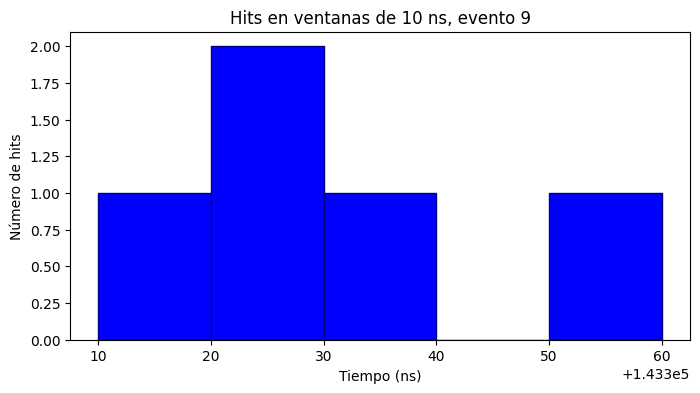

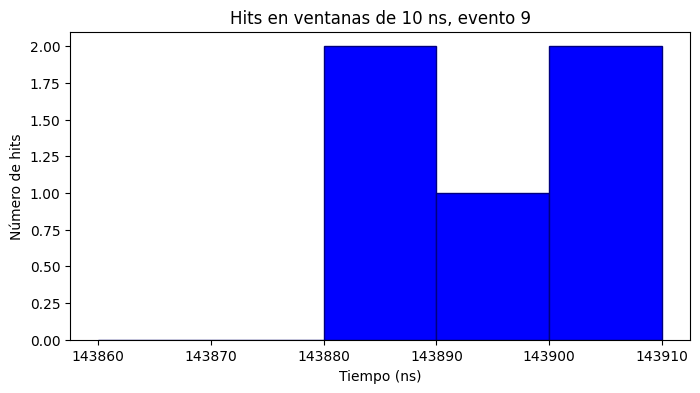

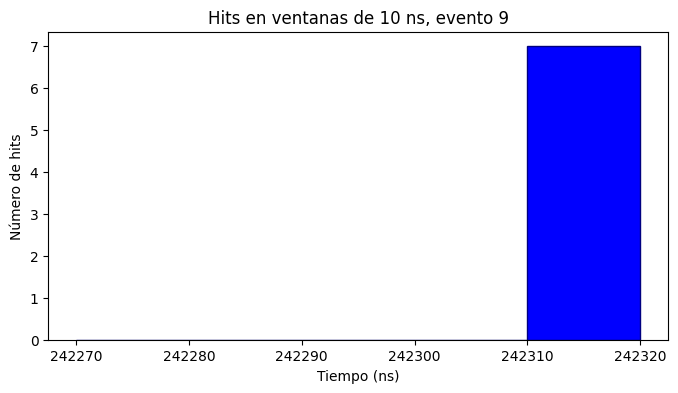

In [ ]:
trigger_times_half = dict(list(trigger_times.items())[0:10])
print(trigger_times_half)

for event_number in trigger_times_half:
    for start_time in trigger_times_half[event_number]:

        selected_cols = [str(int(start_time) + 10*i) for i in range(5)]
        row = df_nHits.loc[event_number, selected_cols]
        plt.style.use('default')
        plt.figure(figsize=(8, 4))
        plt.bar([int(c) for c in selected_cols], row.values, width=10, color='blue', align='edge', edgecolor='navy')
        plt.xlabel('Tiempo (ns)')
        plt.ylabel('Número de hits')
        plt.title(f'Hits en ventanas de 10 ns, evento {event_number}')
        plt.show()

In [14]:
import matplotlib
#matplotlib.use('Agg')
import matplotlib.colors as colors
sys.path.append("/home/cgarcia_2002/WCTE_event_display-main/WCTE_event_display-main")

from EventDisplay import EventDisplay

(2014,)


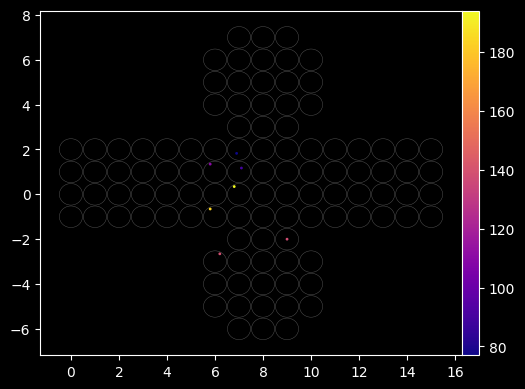

In [31]:
t_evento = 225110
delta = 50
event_id = 0

# Leer datos
times = tree["hit_pmt_times"].array(library="np")
charges = tree["hit_pmt_charges"].array(library="np")
slot_ids = tree["hit_mpmt_slot_ids"].array(library="np")
pmt_positions = tree["hit_pmt_position_ids"].array(library="np")

t = times[event_id]
q = charges[event_id]
slot = slot_ids[event_id]
pos = pmt_positions[event_id]

# Filtrar por tiempo cercano al evento deseado
mask = (t > t_evento - delta) & (t < t_evento + delta)

# Aplicar filtro
t = t[mask]
q = q[mask]
slot = slot[mask]
pos = pos[mask]

# Combinar en canal único para EventDisplay
channel_ids = slot * 19 + pos

# ---------- VISUALIZAR EVENTO ----------

# Crear instancia del EventDisplay
eventDisplay = EventDisplay()
eventDisplay.load_mPMT_positions('mPMT_2D_projection_angles.csv')
eventDisplay.load_wcsim_tubeno_mapping("geofile_WCTE.txt")

# Procesar y graficar
data_to_plot = eventDisplay.process_data(channel_ids, q)
eventDisplay.plotEventDisplay(data_to_plot, color_norm=colors.Normalize(), style="dark_background")
plt.show()
#plt.savefig(f"evento_filtrado_{event_id}_{t_evento}.png")
#plt.close()


In [13]:
mis_datos = {}

with open('datos_por_filas.csv', 'r') as f:
    reader = csv.reader(f)
    for fila in reader:
        if not fila:
            continue  # saltar filas vacías
        clave = fila[0]
        valores = fila[1:]
        mis_datos[clave] = valores
        

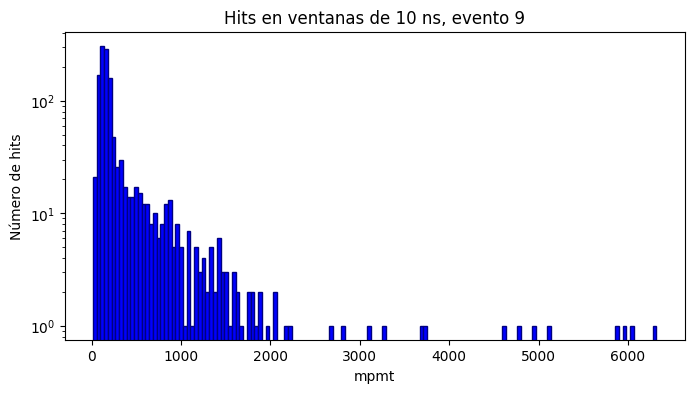

In [32]:
event_id =  0
hit_pmt_channel = tree["hit_mpmt_card_ids"].array(library="np")[event_id] 
hit_pmt_position = tree["hit_mpmt_slot_ids"].array(library="np")[event_id] 
times_branch = tree["hit_pmt_charges"].array(library="np")[event_id]

# Definimos el rango de interés
"""t_min = 225110
t_max = t_min + 50

# Seleccionamos los índices de los elementos que cumplen la condición
indices_en_rango = np.where((times_branch >= t_min) & (times_branch < t_max))[0]

mpmt_id = hit_pmt_channel[indices_en_rango]
"""


plt.style.use('default')
plt.figure(figsize=(8, 4))
plt.hist(times_branch, bins=150, color='blue', edgecolor='navy')
plt.xlabel('mpmt')
plt.ylabel('Número de hits')
plt.title(f'Hits en ventanas de 10 ns, evento {event_number}')
plt.yscale('log')
plt.show()

In [26]:
num_distintos = len(np.unique(mpmt_id))
print("Cantidad de números distintos en mpmt_id:", num_distintos)

Cantidad de números distintos en mpmt_id: 44
